# Robot vision

In [2]:
%%html
<style>
div.cell.selected .output {
    min-height: 400px !important;  /* your desired max-height here */
}
</style>

In [3]:
%matplotlib inline
import cv2
from matplotlib import pyplot as plt
import numpy as np
from urllib import request

from __future__ import print_function
from IPython.display import clear_output, display
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

http://giusedroid.blogspot.com.br/2015/04/blog-post.html

http://petrkout.com/electronics/low-latency-0-4-s-video-streaming-from-raspberry-pi-mjpeg-streamer-opencv/

In [4]:
from contextlib import closing
camera_addr = "http://192.168.0.22:8000/camera"

def get_jpg():
    with closing(request.urlopen(camera_addr)) as stream:
        bytes = stream.read(50 * 1024)
        a, b = bytes.find(b'\xff\xd8'), bytes.find(b'\xff\xd9')
        if a != -1 and b != -1:
            return bytes[a:b+2]

In [5]:
def process_jpg(jpg):
    img = cv2.imdecode(np.fromstring(jpg, dtype=np.uint8), 3)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray,(5,5),0)
    
    ret, thresh1 = cv2.threshold(
        blur, 70, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

    im2, contours, hierarchy = cv2.findContours(
        thresh1, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    max_area = 0
    for i in range(len(contours)):
        cnt = contours[i]
        area = cv2.contourArea(cnt)
        if area > max_area:
            max_area = area
            ci = i

    cnt = contours[ci]
    hull = cv2.convexHull(cnt)
    drawing = np.zeros(img.shape, np.uint8)
    cv2.drawContours(drawing, [cnt], 0, (0,255,0), 2)
    cv2.drawContours(drawing, [hull], 0, (0,0,255), 2)
    
    return img, drawing

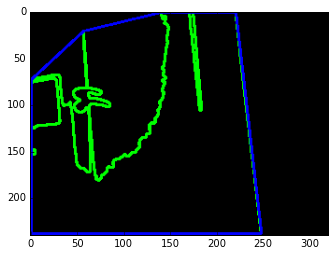

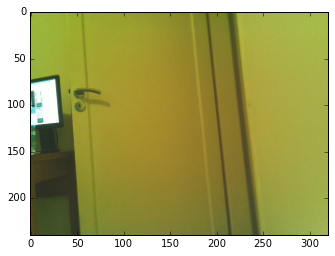

In [6]:
jpg = get_jpg()
if jpg:
    img, drawing = process_jpg(jpg)
    
    plt.imshow(drawing)
    plt.show()
    
    plt.imshow(img)
    plt.show()
else:
    print("Image is empty")

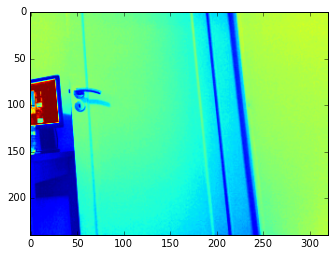

In [7]:
gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
plt.imshow(gray)
plt.show()

https://github.com/opencv/opencv/issues/6487

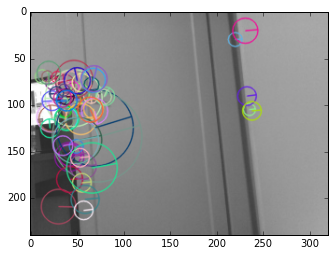

In [8]:
surf = cv2.xfeatures2d.SURF_create()
(kp, descs) = surf.detectAndCompute(gray, None)
imgsurf = cv2.drawKeypoints(gray, kp, img.copy(), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(imgsurf)

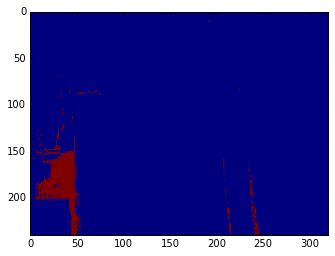

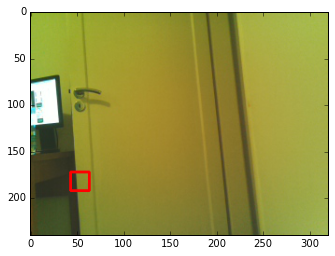

In [9]:
def color_mask(img, h, s, v, hmax, smax, vmax):
    hsvimg = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    return cv2.inRange(hsvimg, (h, s, v), (hmax, smax, vmax))

def mask_center_xy(mask):
    moments = cv2.moments(mask)
    area = moments['m00']
    x, y = 0, 0
    if area > 10000:
        x = int(moments['m10'] / area)
        y = int(moments['m01'] / area)
    return (x,y)

boundaries = globals().get("boundaries", (0, 0, 0, 0, 0, 0))

@interact(
    h=widgets.IntSlider(min=0,max=255,step=1, value=boundaries[0]),
    s=widgets.IntSlider(min=0,max=255,step=1, value=boundaries[1]),
    v=widgets.IntSlider(min=0,max=255,step=1, value=boundaries[2]),
    hmax=widgets.IntSlider(min=0,max=255,step=1, value=boundaries[3]),
    smax=widgets.IntSlider(min=0,max=255,step=1, value=boundaries[4]),
    vmax=widgets.IntSlider(min=0,max=255,step=1, value=boundaries[5])
)
def get_boundaries(h, s , v, hmax, smax, vmax):
    global boundaries
    boundaries = (h, s, v, hmax, smax, vmax)
    mask = color_mask(img, h, s, v, hmax, smax, vmax)

    plt.imshow(mask)
    plt.show()

    x, y = mask_center_xy(mask)
    imgmoments = cv2.rectangle(img.copy(), (x - 10, y - 10), (x + 10, y + 10), (255, 0, 0), 2)
    plt.imshow(imgmoments)
    plt.show()

In [10]:
def lookto(anglx, angly):    
    move_to_url = 'http://192.168.0.22:8000/robot/look-to/?x={}&y={}'.format(anglx, angly)
    print("look to:", anglx, angly)
    request.urlopen(move_to_url).close()

In [11]:
import math

anglx, angly = 90, 90;
def look_to_color(boundaries):
    global anglx, angly, img

    jpg = get_jpg()
    img, _ = process_jpg(jpg)
    mask = color_mask(img, *boundaries)
    x, y = mask_center_xy(mask)

    center = (int(len(img[0])/2), int(len(img)/2))
    dist_x = int(center[0] - x)
    dist_y = int(center[1] - y)
    
    if dist_x >= len(img[0]) / 2:
        anglx = 90
    if dist_y >= len(img) / 2:
        angly = 90
    
    if dist_x > 5 or dist_x < -5:
        if dist_x > 0:
            anglx = anglx + 1;
        else:
            anglx = anglx - 1;
    
    if dist_y > 5 or dist_y < -5:
        if dist_y < 0:
            angly = angly + 1;
        else:
            angly = angly - 1;
    
    lookto(anglx, angly)
    
    print("x,y=({},{}) size({}, {}) dist({},{}) angl({},{})".
          format(x, y, len(img[0]), len(img), dist_x, dist_y, anglx, angly))
    
    imgmoments = cv2.rectangle(img.copy(), (x - 10, y - 10), (x + 10, y + 10), (255, 0, 0), 2)
    imgmoments = cv2.rectangle(imgmoments, center, center, (255, 0, 0), 5)
    imgmoments = cv2.line(imgmoments, center, (center[0] - dist_x, center[1] - dist_y), (0, 255, 255), 2)
    plt.imshow(imgmoments)
    plt.show()
    


In [12]:
import time

@interact(on=False)
def run(on):
    if not on:
        return
    
    try:
        while True:
            clear_output(wait=True)
            look_to_color(boundaries)
            time.sleep(0.1)
    except KeyboardInterrupt:
        pass

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


look to: 92 90
x,y=(83,174) size(320, 240) dist(77,-54) angl(92,90)


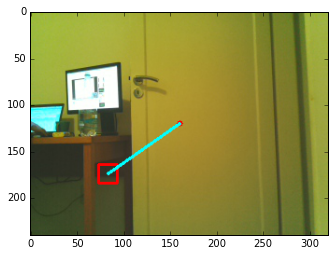

look to: 100 90


In [15]:
look_to_color(boundaries)
lookto(100, 90)

0.065


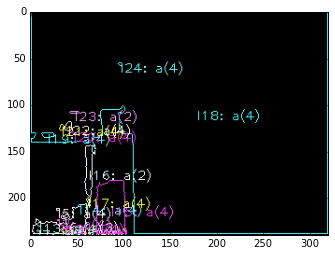

In [19]:
from random import random

colors = []

arc = 0

@interact(arc=widgets.FloatSlider(min=0.001,max=0.1,step=0.001, value=0.065))
def draw_contours(*args, **kwargs):    
#     while on:
    clear_output(wait=True)
    jpg = get_jpg()
    img, _ = process_jpg(jpg)
    color_mask = np.zeros(img.shape, dtype="uint8")

    blurred = cv2.GaussianBlur(img.copy(), (5, 5), 0)
    gray = cv2.cvtColor(blurred, cv2.COLOR_BGR2GRAY)
    lab = cv2.cvtColor(blurred, cv2.COLOR_BGR2LAB)
    thresh = cv2.threshold(gray, 60, 255, cv2.THRESH_BINARY)[1]

    cnts = cv2.findContours(thresh.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cntsimg, cnts = cnts[:2]
        
    global arc
    arc = kwargs.get("arc", arc)
    mask = np.zeros(img.shape, dtype="uint8")
    
    for i, c in enumerate(cnts):
        color = [255, 255, 255]
        color[int(random() * 3)] = int(random() * 255)
        colors.append(color)

        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, arc * peri, True)
    
        if len(approx) < 10:
            m = cv2.moments(c)
            if m["m00"] > 0:
                cx = int((m["m10"] / m["m00"]))
                cy = int((m["m01"] / m["m00"]))
                label = "I{}: a({})".format(i, len(approx))
#                 print(label)
                cv2.putText(mask, label, (cx, cy + 10), cv2.FONT_HERSHEY_PLAIN, 1, color, 1)
                
                mask = cv2.drawContours(mask, [c], 0, color, 1)
                # mask = cv2.erode(mask, None, iterations=2)
                # mean = cv2.mean(img, mask=mask)[:3]
    btn = globals().get("btn")
    print(arc)
    plt.imshow(mask)
    plt.show()
    
btn = widgets.Button(description="Run")
btn.on_click(lambda x: draw_contours(arc))
draw_contours()
btn